In [0]:
#!pip install vaderSentiment

In [0]:
import json
import requests
import re
import os
import pandas as pd
from datetime import datetime
from gensim.parsing.preprocessing import remove_stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
%matplotlib inline
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [0]:
def clean_text(x, label = ''):
    try:
        x = re.sub(r"<[^>]+>", "", x)
        x = re.sub(r"\bgt\b", "", x)
        x = re.sub(r"[^A-Za-z(),!?\'\`]", " ", x)
        x = re.sub(r"\'s", " \'s", x)
        x = re.sub(r"\'ve", " \'ve", x)
        x = re.sub(r"n\'t", " n\'t", x)
        x = re.sub(r"\'re", " \'re", x)
        x = re.sub(r"\'d", " \'d", x)
        x = re.sub(r"\'ll", " \'ll", x)
        x = re.sub(r",", " ", x)
        x = re.sub(r"!", " ", x)
        x = re.sub(r"\(", "", x)
        x = re.sub(r"\)", "", x)
        x = re.sub(r"\?", "", x)
        x = re.sub(r"/", "", x)
        x = re.sub(r"\s{2,}", " ", x)
        x = re.sub(r"\b"+label+"\b", "", x)
        return x.lower()
    except:
        return ''

In [0]:
def get_data(label):
    if label+'.json' not in os.listdir():
        url = 'https://a.4cdn.org/'+label+'/catalog.json'
        r = requests.get(url, allow_redirects=True)
        open(label+'.json', 'wb').write(r.content)

    out = json.load(open(label+'.json',))
    texts = []
    times = []
    num_replies = []
    replies = []
    for i in range(len(out)):
        for j in range(len(out[i]['threads'])):
            obj = out[i]['threads'][j]
            if 'com' in obj.keys():
                com = obj['com']
                texts.append(clean_text(com, label))
            times.append(datetime.utcfromtimestamp(obj['time']).strftime('%Y-%m-%d %H:%M:%S'))
            num_replies.append(obj['replies'])
            if 'last_replies' in obj.keys():
                obj_reply = obj['last_replies']
                replies.append(''.join(list(map(lambda x: clean_text(obj_reply[x]['com'], label) if 'com' in obj_reply[x].keys() else '', range(len(obj_reply))))))
            else:
                replies.append('')

    return zip(texts, times, num_replies, replies, map(lambda x: label, range(len(texts))))

In [39]:
%%time
df = pd.concat([pd.DataFrame(list(get_data('g')), columns = ['text', 'time', 'num_replies', 'last_replies', 'label']),
                pd.DataFrame(list(get_data('tv')), columns = ['text', 'time', 'num_replies', 'last_replies', 'label']),
                pd.DataFrame(list(get_data('ck')), columns = ['text', 'time', 'num_replies', 'last_replies', 'label']),
                pd.DataFrame(list(get_data('lit')), columns = ['text', 'time', 'num_replies', 'last_replies', 'label'])])
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by = 'time', ascending = True)
df = df.reset_index(drop = True)

CPU times: user 136 ms, sys: 6.96 ms, total: 143 ms
Wall time: 143 ms


In [40]:
df.head()

,text,time,num_replies,last_replies,label
0,the g wiki http wiki installgentoo com g is fo...,2015-12-21 01:03:52,1,,g
1,lit is for the discussion of literature speci...,2018-10-14 17:26:30,0,,lit
2,share stories of you working in the food servi...,2020-05-04 07:44:36,243,what annoys me is you have to order them well...,ck
3,beer thread today s topic do real men drink be...,2020-05-05 02:54:44,133,put it in cold water overnight a generous tea...,ck
4,can we just be honest to fucking god that ever...,2020-05-06 00:09:47,305,this is one of the only threads on the entire...,lit


In [41]:
%%time
#Don't remove stopwords if you're using LSTMs
df['text'] = df['text'].apply(remove_stopwords)
df['last_replies'] = df['last_replies'].apply(remove_stopwords)

CPU times: user 19.1 ms, sys: 78 µs, total: 19.2 ms
Wall time: 19.6 ms


In [0]:
def lemmatizer(x):
    return ' '.join([token.lemma_ for token in nlp(x)])

In [43]:
%%time
df['text'] = df['text'].apply(lemmatizer)
df['last_replies'] = df['last_replies'].apply(lemmatizer)

CPU times: user 4.99 s, sys: 1.86 ms, total: 4.99 s
Wall time: 4.99 s


In [44]:
df.head()

,text,time,num_replies,last_replies,label
0,g wiki http wiki installgentoo com g discussio...,2015-12-21 01:03:52,1,,g
1,lit discussion literature specifically book fi...,2018-10-14 17:26:30,0,,lit
2,share story work food service industry bartend...,2020-05-04 07:44:36,243,annoy order soggy mess s hipster feel cool ord...,ck
3,beer thread today s topic real man drink beer ...,2020-05-05 02:54:44,133,cold water overnight generous teaspoon quart w...,ck
4,honest fuck god heidegger wittgenstein utterly...,2020-05-06 00:09:47,305,threads entire board actual substance faggot p...,lit


#Word Clouds for the 100 most common words in the data
## For the entire dataset

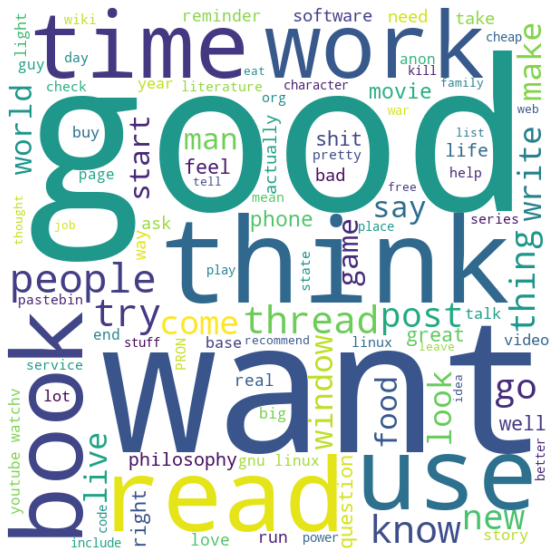

In [45]:
stopwords = list(STOPWORDS) + ['https', 'will', 'amp', 'add', 'fucking', 've', 'isn', 'quot', 'fuck']
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['text']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

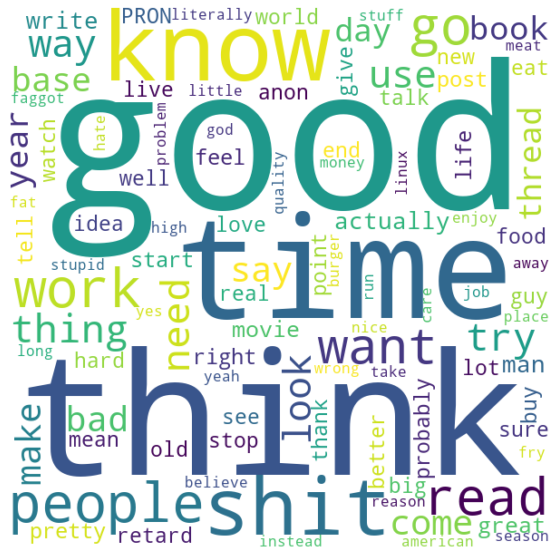

In [46]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['last_replies']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## For Technology

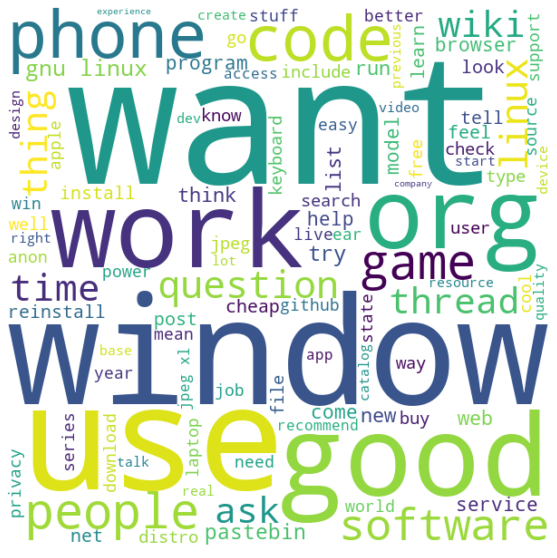

In [47]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['text'][df['label'] == 'g']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

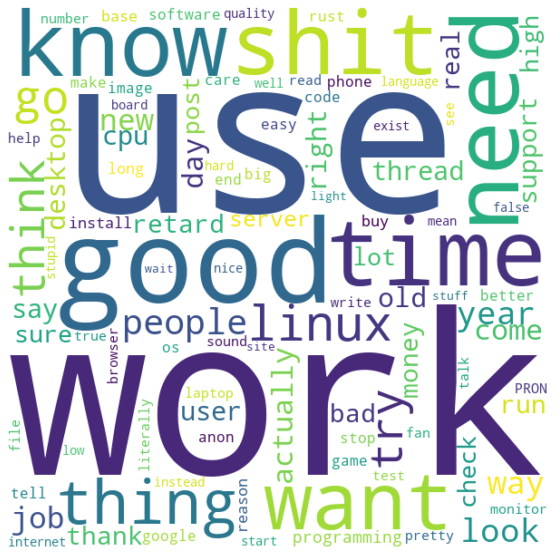

In [48]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['last_replies'][df['label'] == 'g']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## For TV & Film

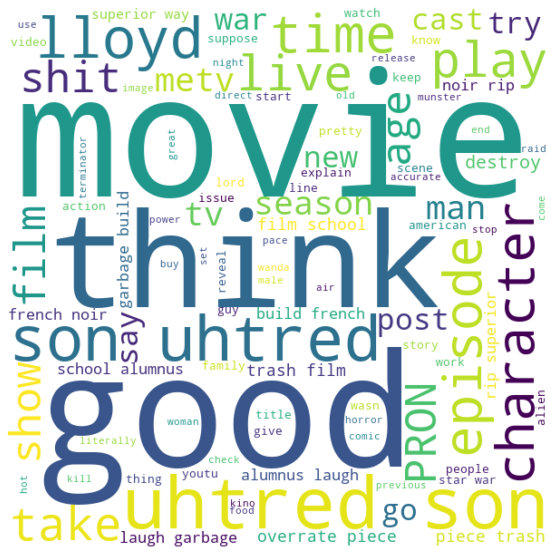

In [49]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['text'][df['label'] == 'tv']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

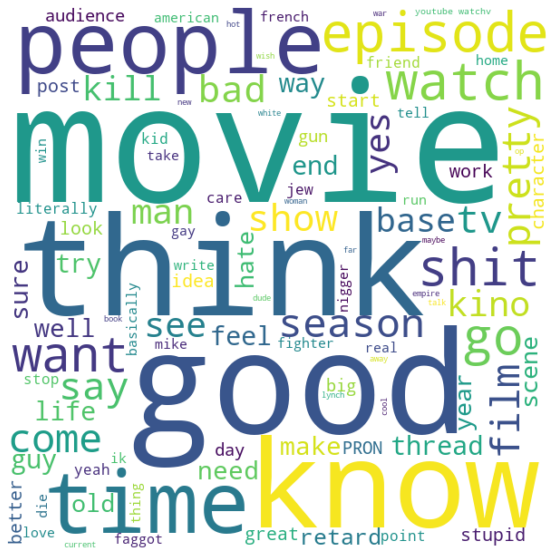

In [50]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['last_replies'][df['label'] == 'tv']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## For Food & Cooking

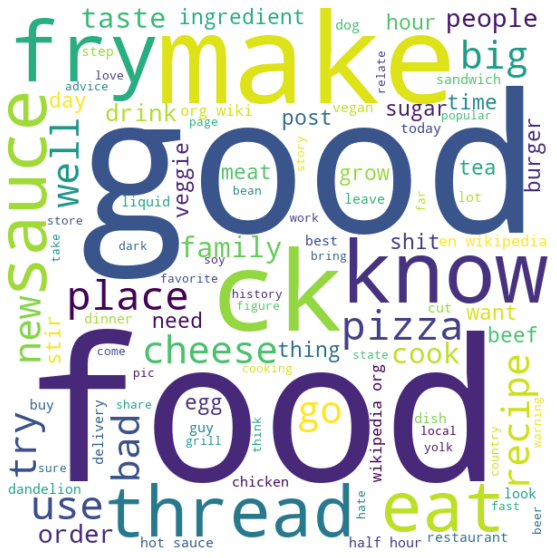

In [51]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['text'][df['label'] == 'ck']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

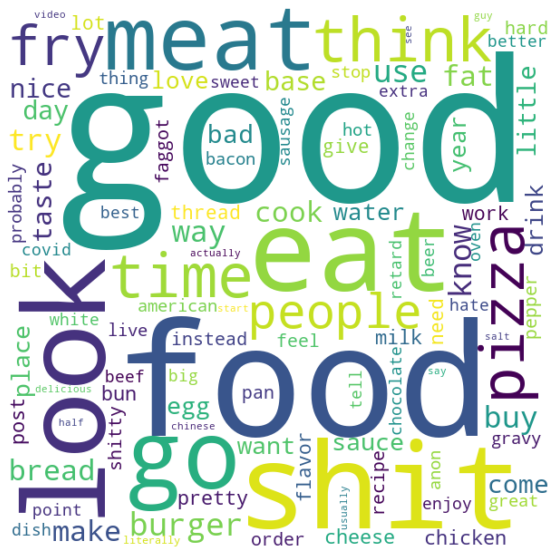

In [52]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['last_replies'][df['label'] == 'ck']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## For Literature

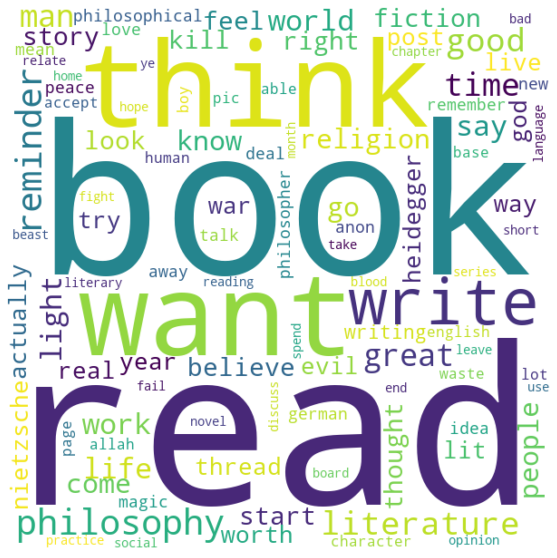

In [53]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['text'][df['label'] == 'lit']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

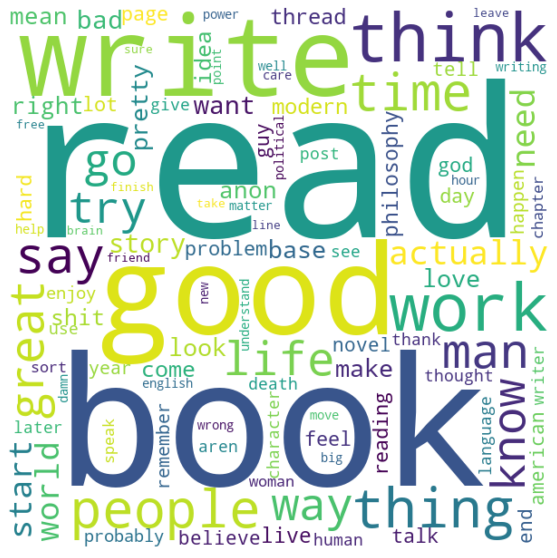

In [54]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['last_replies'][df['label'] == 'lit']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Number of Replies 
The number of replies a post gets can be considered as an indicator of the level of engagement that the post has. Thus, looking at the distibution of the number of replies is important. 
## Histogram of Number of Replies 
### For the entrie dataset

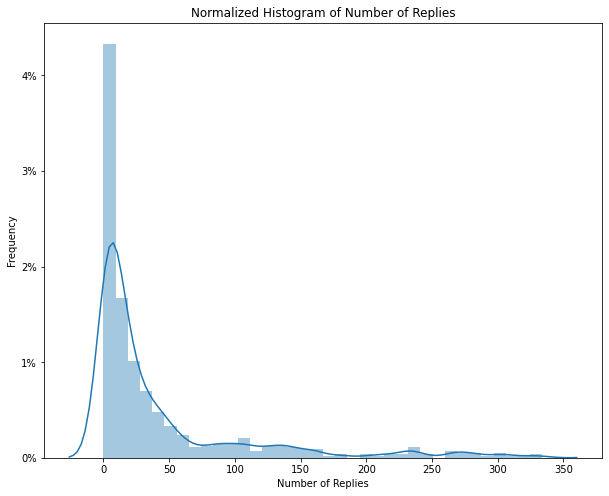

In [55]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sns.distplot(df['num_replies'], ax = ax)
vals = ax.get_yticks()
vals = [str(int(x*100))+'%' for x in vals]
ax.set_yticklabels(vals)
plt.title("Normalized Histogram of Number of Replies")
plt.ylabel('Frequency')
plt.xlabel('Number of Replies')
plt.show()

### For Technology

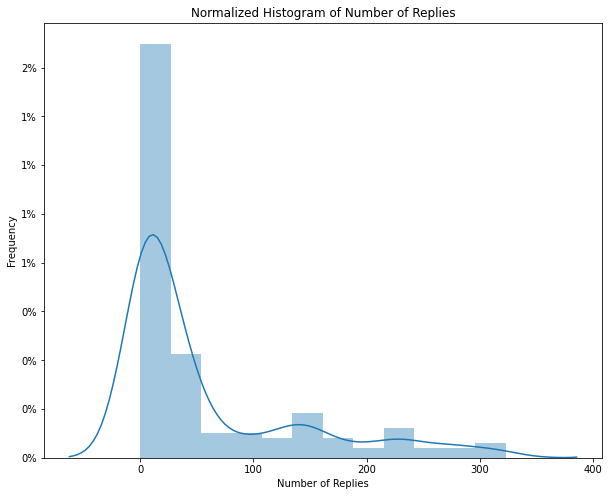

In [56]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sns.distplot(df['num_replies'][df['label'] == 'g'], ax = ax)
vals = ax.get_yticks()
vals = [str(int(x*100))+'%' for x in vals]
ax.set_yticklabels(vals)
plt.title("Normalized Histogram of Number of Replies")
plt.ylabel('Frequency')
plt.xlabel('Number of Replies')
plt.show()

### For TV & Film

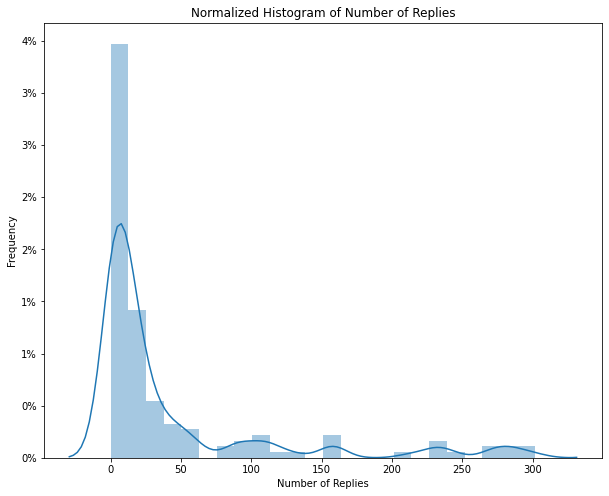

In [57]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sns.distplot(df['num_replies'][df['label'] == 'tv'], ax = ax)
vals = ax.get_yticks()
vals = [str(int(x*100))+'%' for x in vals]
ax.set_yticklabels(vals)
plt.title("Normalized Histogram of Number of Replies")
plt.ylabel('Frequency')
plt.xlabel('Number of Replies')
plt.show()

### For Food & Cooking

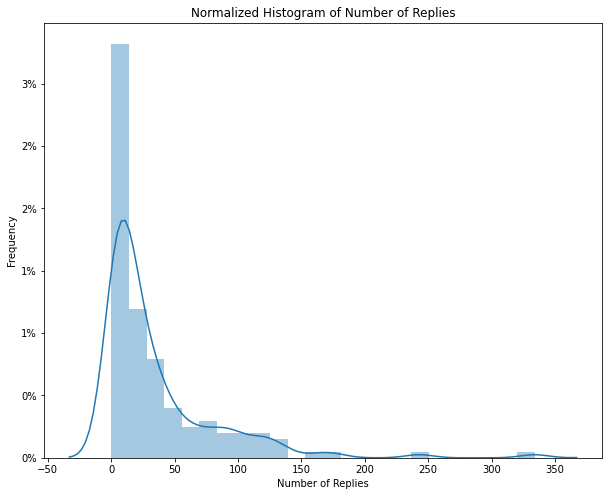

In [58]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sns.distplot(df['num_replies'][df['label'] == 'ck'], ax = ax)
vals = ax.get_yticks()
vals = [str(int(x*100))+'%' for x in vals]
ax.set_yticklabels(vals)
plt.title("Normalized Histogram of Number of Replies")
plt.ylabel('Frequency')
plt.xlabel('Number of Replies')
plt.show()

### For Literature

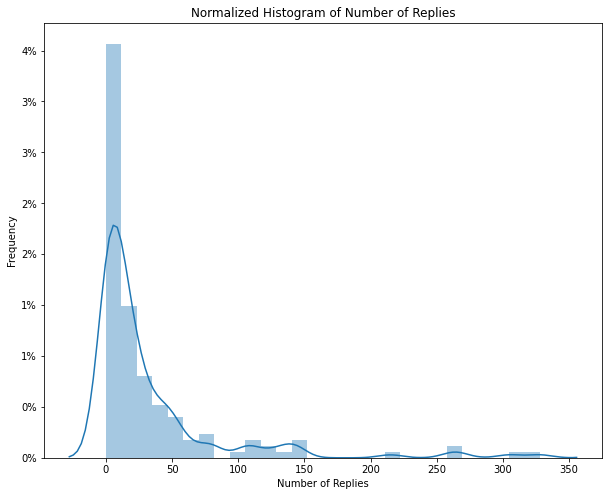

In [59]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sns.distplot(df['num_replies'][df['label'] == 'lit'], ax = ax)
vals = ax.get_yticks()
vals = [str(int(x*100))+'%' for x in vals]
ax.set_yticklabels(vals)
plt.title("Normalized Histogram of Number of Replies")
plt.ylabel('Frequency')
plt.xlabel('Number of Replies')
plt.show()

It can be observed from the plots that the distribution for the number of replies to each post is approximately the same. Posts get very few replies and most of them don't get any replies altogether.

## Boxplot for the Number of Replies for different Channels

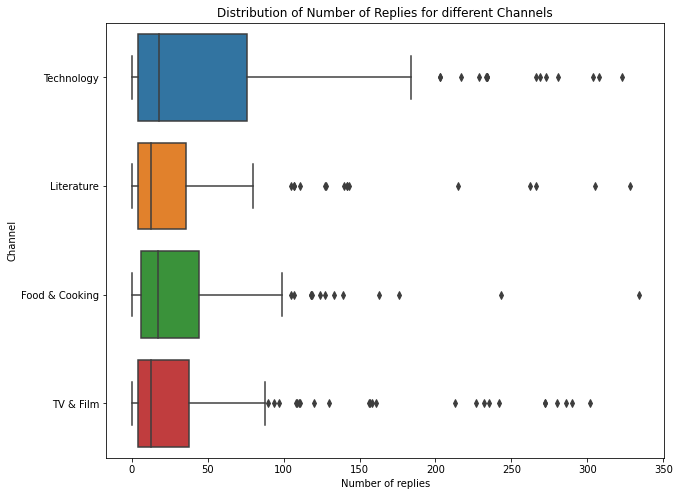

In [60]:
plt.figure(figsize=(10,8))
ax = plt.gca()
f = sns.boxplot(x="num_replies", y="label", data=df, ax=ax)
ax.set_yticklabels(['Technology', 'Literature', 'Food & Cooking','TV & Film'])
plt.ylabel("Channel")
plt.xlabel("Number of replies")
plt.title("Distribution of Number of Replies for different Channels")
plt.show()

It can be obeserved that while the mean are very close to each other, Technology on average has the highest number of replies. The range of the number of replies for technology is also much more spread out, indicating that some posts in technology get a significantly more replies than the average post across channels. 

# Sentiment of the posts

In [61]:
%%time
df['text_neg'] = df['text'].apply(lambda x: analyser.polarity_scores(x)['neg'])
df['text_neu'] = df['text'].apply(lambda x: analyser.polarity_scores(x)['neu'])
df['text_pos'] = df['text'].apply(lambda x: analyser.polarity_scores(x)['pos'])

CPU times: user 402 ms, sys: 66 µs, total: 402 ms
Wall time: 404 ms


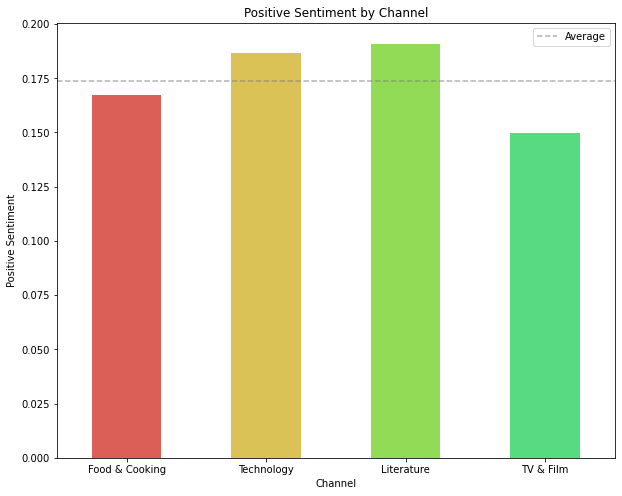

In [62]:
plt.figure(figsize = (10,8))
ax = plt.gca()
df.groupby('label')['text_pos'].mean().plot(kind = 'bar', ax = ax, rot = 0, color = sns.color_palette("hls", 8))
plt.axhline(y = df['text_pos'].mean(), linestyle = '--', color = 'grey', alpha = 0.6, label = 'Average')
vals = ax.get_xticks()
ax.set_xticklabels(['Food & Cooking', 'Technology', 'Literature', 'TV & Film'])
plt.xlabel('Channel')
plt.ylabel("Positive Sentiment")
plt.title('Positive Sentiment by Channel')
plt.legend(['Average'])
plt.show()

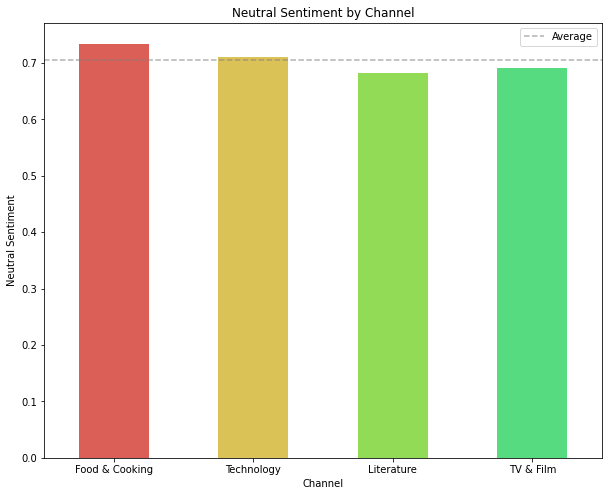

In [63]:
plt.figure(figsize = (10,8))
ax = plt.gca()
df.groupby('label')['text_neu'].mean().plot(kind = 'bar', ax = ax, rot = 0, color = sns.color_palette("hls", 8))
plt.axhline(y = df['text_neu'].mean(), linestyle = '--', color = 'grey', alpha = 0.6, label = 'Average')
vals = ax.get_xticks()
ax.set_xticklabels(['Food & Cooking', 'Technology', 'Literature', 'TV & Film'])
plt.xlabel('Channel')
plt.ylabel("Neutral Sentiment")
plt.title('Neutral Sentiment by Channel')
plt.legend(['Average'])
plt.show()

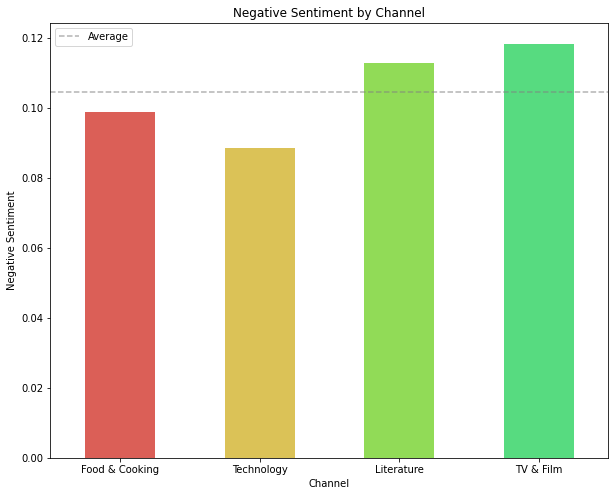

In [64]:
plt.figure(figsize = (10,8))
ax = plt.gca()
df.groupby('label')['text_neg'].mean().plot(kind = 'bar', ax = ax, rot = 0, color = sns.color_palette("hls", 8))
plt.axhline(y = df['text_neg'].mean(), linestyle = '--', color = 'grey', alpha = 0.6, label = 'Average')
vals = ax.get_xticks()
ax.set_xticklabels(['Food & Cooking', 'Technology', 'Literature', 'TV & Film'])
plt.xlabel('Channel')
plt.ylabel("Negative Sentiment")
plt.title('Negative Sentiment by Channel')
plt.legend(['Average'])
plt.show()

#Sentiment of Replies

In [65]:
%%time
df['last_replies_neg'] = df['last_replies'].apply(lambda x: analyser.polarity_scores(x)['neg'])
df['last_replies_neu'] = df['last_replies'].apply(lambda x: analyser.polarity_scores(x)['neu'])
df['last_replies_pos'] = df['last_replies'].apply(lambda x: analyser.polarity_scores(x)['pos'])

CPU times: user 912 ms, sys: 978 µs, total: 913 ms
Wall time: 917 ms


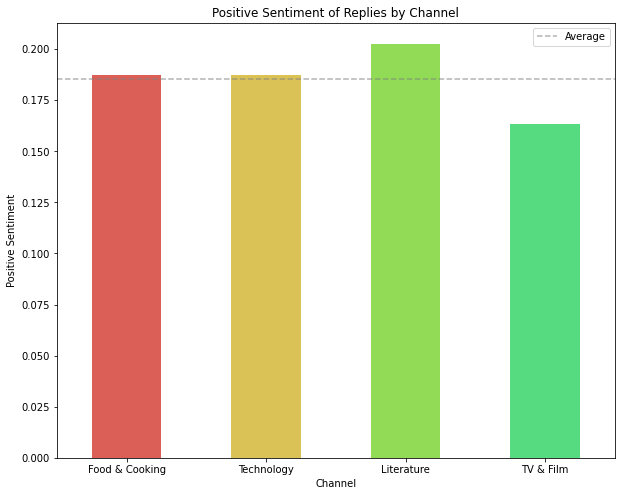

In [66]:
plt.figure(figsize = (10,8))
ax = plt.gca()
df.groupby('label')['last_replies_pos'].mean().plot(kind = 'bar', ax = ax, rot = 0, color = sns.color_palette("hls", 8))
plt.axhline(y = df['last_replies_pos'].mean(), linestyle = '--', color = 'grey', alpha = 0.6, label = 'Average')
vals = ax.get_xticks()
ax.set_xticklabels(['Food & Cooking', 'Technology', 'Literature', 'TV & Film'])
plt.xlabel('Channel')
plt.ylabel("Positive Sentiment")
plt.title('Positive Sentiment of Replies by Channel')
plt.legend(['Average'])
plt.show()

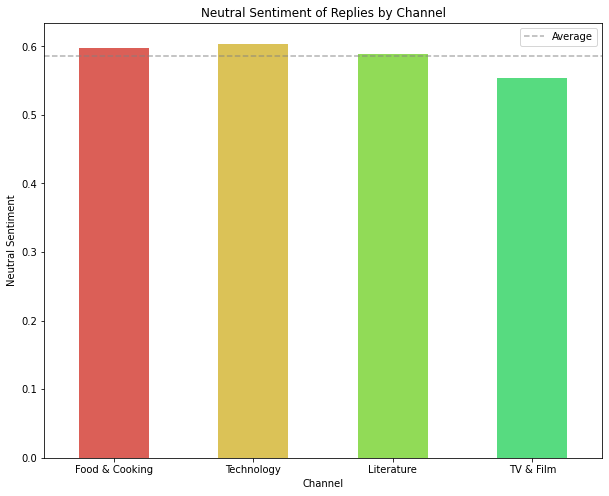

In [67]:
plt.figure(figsize = (10,8))
ax = plt.gca()
df.groupby('label')['last_replies_neu'].mean().plot(kind = 'bar', ax = ax, rot = 0, color = sns.color_palette("hls", 8))
plt.axhline(y = df['last_replies_neu'].mean(), linestyle = '--', color = 'grey', alpha = 0.6, label = 'Average')
vals = ax.get_xticks()
ax.set_xticklabels(['Food & Cooking', 'Technology', 'Literature', 'TV & Film'])
plt.xlabel('Channel')
plt.ylabel("Neutral Sentiment")
plt.title('Neutral Sentiment of Replies by Channel')
plt.legend(['Average'])
plt.show()

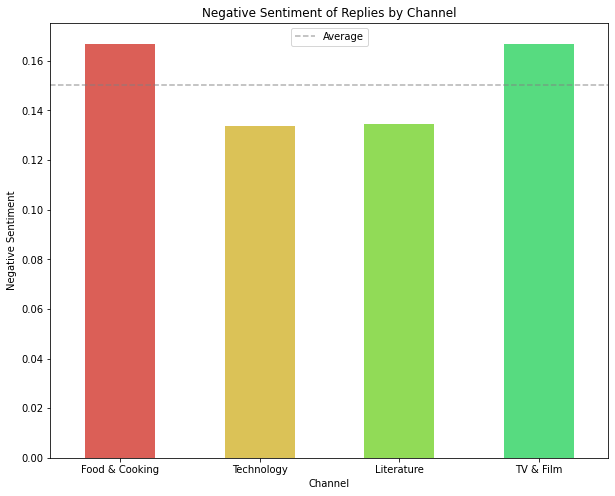

In [68]:
plt.figure(figsize = (10,8))
ax = plt.gca()
df.groupby('label')['last_replies_neg'].mean().plot(kind = 'bar', ax = ax, rot = 0, color = sns.color_palette("hls", 8))
plt.axhline(y = df['last_replies_neg'].mean(), linestyle = '--', color = 'grey', alpha = 0.6, label = 'Average')
vals = ax.get_xticks()
ax.set_xticklabels(['Food & Cooking', 'Technology', 'Literature', 'TV & Film'])
plt.xlabel('Channel')
plt.ylabel("Negative Sentiment")
plt.title('Negative Sentiment of Replies by Channel')
plt.legend(['Average'])
plt.show()